- Youjun Chen
- Dec 08th, 2020
- I affirm that I personally wrote the text, code, and comments in this notebook.

# NLP Problem

In this problem, you will study the sentiment in a data set of tweets collected during the COVID-19 pandemic. To load the data set, run this block: 

In [1]:
import pandas as pd

def grab_tweets():
    """
    The user supplied these data already split into training and test sets. 
    This function downloads and combines them, returning a single data frame.
    No arguments. 
    """

    url1 = "https://raw.githubusercontent.com/PhilChodrow/PIC16A/master/datasets/Corona_NLP_train.csv"
    url2 = "https://raw.githubusercontent.com/PhilChodrow/PIC16A/master/datasets/Corona_NLP_test.csv"
    
    df1 = pd.read_csv(url1, encoding='iso-8859-1')
    df2 = pd.read_csv(url2, encoding='iso-8859-1')
    
    return pd.concat((df1, df2), axis = 0).reset_index().drop("index", axis = 1)

df = grab_tweets()

Perform a sentiment analysis of this data set. 

Many decisions are up to you. What machine learning method will you choose? How will you treat the `Sentiment` column and turn it into a target variable? Feel free to talk on Campuswire about various possibilities. You are welcome to ask me as well; however, I am likely to respond to questions like "Should I do X?" with answers like "Did you try it? What alternatives did you consider?"

For full credit, you should do the following:  

1. Explore the data set a bit. Figure out what each column means and develop a strategy for how you will use or not use it. Show your steps. 
1. Show that your model can make predictions of sentiment on unseen tweets.
2. Show that your model can produce reasonable-looking lists of strong positive and strongly negative words. 
3. Display three tweets in which your model made a mistake -- e.g. it classified the tweet as positive when in fact it was negative, or vice-versa. 
4. Include liberal comments and surrounding text to explain your steps. If you define any functions, you must also include helpful docstrings. 
5. Most instances of for-loops will be docked a few points. There may be exceptions, but I can't think of any at the moment. Try to do the entire problem with no for-loops at all. 

OPTIONALLY, you may choose to look into the text classification tools in the `nltk` package. In this course, we have mostly treated `nltk` as a convenience tool for accessing certain data sets. However, `nltk` also implements its own versions of a number of highly useful functions for text analysis, including sentiment analysis. Section 1.3 of [this chapter](https://www.nltk.org/book/ch06.html) of the `nltk` manual can help you get started. Using `nltk` for this problem might help you get some better results and learn some nifty tricks, but is not at all required. 

#### Your Solution

In [2]:
# start here, but a good solution will surely require multiple code and markdown text blocks. 

# required libraries
import random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import warnings 
warnings.filterwarnings("ignore") #ignore harmless warnings

random.seed(1234) #fixed randomness

### Explore and process data 

In [3]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
44950,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
44951,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
44952,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
44953,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [4]:
df.Sentiment.value_counts() #check how many types of sentiment

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [5]:
# encode the 5 types of sentiments into 0-4
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Sentiment_code'] = le.fit_transform(df.Sentiment)

# to identify which integer what each integer label refers to
df['Sentiment_code'].value_counts() 

4    12369
2    10958
3     8332
1     7223
0     6073
Name: Sentiment_code, dtype: int64

In [6]:
# stores the encoding 
sentiment = ['Extremely Negative', 'Extremely Positive', 'Neutral','Negative','Positive']

In [7]:
# process OriginalTweet
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(max_df = 0.2, min_df = 30, stop_words = 'english')

counts = vec.fit_transform(df['OriginalTweet'])
count_df = pd.DataFrame(counts.toarray(), columns = vec.get_feature_names()) 

In [8]:
#concatinate df['Sentiment'] with count_df
df1 = pd.concat((df['Sentiment_code'], count_df), axis = 1)
df1.head()

,Sentiment_code,00,000,03,10,100,1000,10downingstreet,11,12,...,yesterday,yo,york,young,youtube,youâ,yâ,zealand,zero,zombie
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split test and train data

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df1, test_size = 0.4)

X_train = train.drop(['Sentiment_code'], axis = 1)
y_train = train['Sentiment_code']

X_test = test.drop(['Sentiment_code'], axis = 1)
y_test = test['Sentiment_code']

### Model training and result inspection
#### Without model tuning

In [13]:
from sklearn.linear_model import SGDClassifier

sgd1 = SGDClassifier()
sgd1.fit(X_train, y_train)
sgd1.score(X_train, y_train)

0.7157898639380121

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd1, X_train, y_train, cv = 5).mean()

0.5329033495151136

In [15]:
sgd1.score(X_test, y_test)

0.5493271048826605

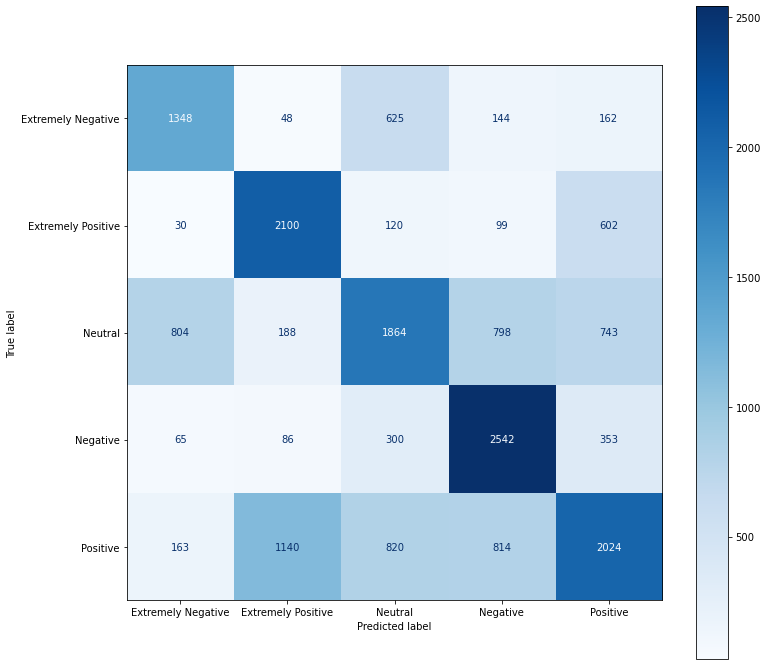

In [16]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
y_test_pred = sgd1.predict(X_test)
c = confusion_matrix(y_test, y_test_pred)

# display the confusion matrix in heatmap format
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12, 12))
confusion_matrix_graph = plot_confusion_matrix(sgd1,X_test, y_test, 
                                               display_labels = sentiment,
                                               cmap=plt.cm.Blues, ax=ax)

From the confusion matrix, we can see that even though the model does not yield a good overall accuracy to all the sentiments, it gives a reasonable prediction for "Extremely positive" and "Extremely negative" sentiments. For the more neutral sentiments, the model is more likely to make wrong predictions.

### Three examples of mistakes

In [41]:
# get the index where the predictions are wrong
test['Sentiment_pred']= y_test_pred
idx1 = test[(test['Sentiment_code'] == 0) & (test['Sentiment_pred'] == 2)].head(1).index
idx2 = test[(test['Sentiment_code'] == 1) & (test['Sentiment_pred'] == 4)].head(1).index
idx3 = test[(test['Sentiment_code'] == 2) & (test['Sentiment_pred'] == 0)].head(1).index

1) Classified as 'Extremely Negative' but predicted as "Neutral":

In [37]:
print(df.loc[idx1].OriginalTweet.values)  

['@FlyingBrussels is a total fraud! Most categories of tickets cancelled because of #Covid_19 are not refund! @EU_Commission @EU_Consumer']


2) Classified as 'Extremely Positive' but predicted as "Positive":

In [40]:
print(df.loc[idx2].OriginalTweet.values)

['Hand washing for #Coronavirus is 4 minutes so you need to put peppermint or disinfectant essential oil in your homemade safer hand sanitizer say doctor and scientist experts, Sarah Westall,YouTube @FoxNews\r\r\nhttps://t.co/MUfxS8rWUc']


3) Classified as 'Neutral' but predicted as "Extremely Negative":

In [39]:
print(df.loc[idx3].OriginalTweet.values)

['Received an email from the company I order my dogs food from saying they have Â\x93unprecedented levels of ordersÂ\x94.... panic buying dog food, the world has gone bonkers! #coronavirus #COVID19']


#### Observations of the mistakes

Sentiments is very subjective. In the mistakes above, espectially in Case 2, it's hard for me to tell whether it is "Extremely positive" or "Positive" just from the words that an individual uses. For the "Neutral" tweet, since it has perspectives of both sides, positive and negative, the prediction depends on the words used in the dataset. If we have a larger dataset, we might be able to improve the accuracy

#### Hyper parameter tuning with grid search

I used another file to run the above to code blocks, and get
- best score : 0.5478443044016573
- parameters:  {'alpha': 0.0001, 'loss': 'log'}

The score barely improves from the original model.

In [33]:
# Generate all combinations of parameters
from sklearn.model_selection import ParameterGrid
grid = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1], # learning rate
}


all_params = ParameterGrid(grid)

In [ ]:
best_score = 0
for params in all_params:
    sgd2 = SGDClassifier(**params).fit(X_train, y_train)  
    cv_score = cross_val_score(sgd2, X_train, y_train, cv = 5).mean()
    if cv_score > best_score:
        best_params = params
        best_score = cv_score
        best_sgd_model = sgd2

print('best score: ', best_score)
print('best parameters: ', best_params)

In [46]:
params = {'alpha': 0.0001, 'loss': 'log'}

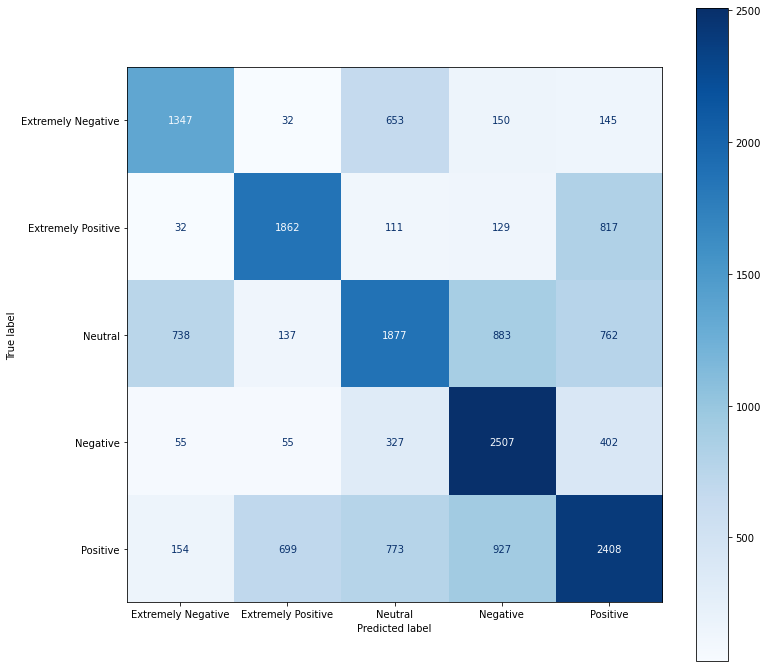

In [47]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
best_sgd_model = SGDClassifier(**params).fit(X_train, y_train) 
y_test_best_pred = best_sgd_model.predict(X_test)
c = confusion_matrix(y_test, y_test_best_pred)

# display the confusion matrix in heatmap format
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12, 12))
confusion_matrix_graph = plot_confusion_matrix(best_sgd_model,X_test, y_test, 
                                               display_labels = sentiment,
                                               cmap=plt.cm.Blues, ax=ax)